Idea of this notebook: 

Time series prediction of daily new Covid-Cases in Chile, with CASEN data as features

Predict what?
* For each region or for the whole country, predict future development (next five or ten days) of Covid cases/deaths
* y = number of cases
* x = casen data + more features (s. time series tips) 

data: CASEN data
Covid data: from MINSAL


1. Read in data: CASEN data, data from MINSAL about regions
2. Data exploration
3. Data visualization
3. Metrics: low RSME (good for time series) 
4. Get features with high correlation
5. build model with those features (maybe LR)
6. GridSearch with different models (LR, Kregressor, RandomForestRegressor) 
7. Findings/conclusion


# Read in data

In [57]:
# Read in libraries
import pandas as pd
pd.options.mode.chained_assignment = None  

import numpy as np

from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns
sns.set_context('poster')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from sklearn.linear_model import LinearRegression


# Read in CASEN data about social vulnerability
casen = pd.read_stata('Casen 2017.dta', convert_categoricals = False)

# Read in data about Covid-19 cases and deaths in Chilean regions
cases_regions = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto3/CasosTotalesCumulativo_T.csv',
    parse_dates = True)

deaths_regions = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto14/FallecidosCumulativo_T.csv',
    parse_dates = True)

# Data exploration

Three dataframes: 
* casen: CASEN data
* cases_regions: data about cases per region
* deaths_regions: data about deaths per region

In [58]:
casen.head(2)

,folio,o,id_vivienda,hogar,region,provincia,comuna,zona,expr,expc,...,hh_d_estado,hh_d_servbas,hh_d_entorno,hh_d_accesi,hh_d_medio,hh_d_appart,hh_d_tsocial,hh_d_seg,pobreza_multi_4d,pobreza_multi_5d
0,1.101100e+11,1,1.101100e+09,1,1,11,1101,1,39,33,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN
1,1.101100e+11,1,1.101100e+09,1,1,11,1101,1,39,33,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [59]:
cases_regions.head(2)

,Region,Arica y Parinacota,Tarapacá,Antofagasta,Atacama,Coquimbo,Valparaíso,Metropolitana,O’Higgins,Maule,Ñuble,Biobío,Araucanía,Los Ríos,Los Lagos,Aysén,Magallanes,Total
0,2020-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2020-03-04,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [60]:
deaths_regions.head(2)

,Region,Arica y Parinacota,Tarapacá,Antofagasta,Atacama,Coquimbo,Valparaíso,Metropolitana,O’Higgins,Maule,Ñuble,Biobío,Araucanía,Los Ríos,Los Lagos,Aysén,Magallanes,Total
0,2020-03-22,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2020-03-23,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [61]:
def first_look(lst):
    """
    Provides useful information about a list of dataframes: Name, Shape, NaNs and describe().
    
    Input: 
        lst(List): List of DataFrames
    
    Output: 
        Prints name, shape, share of NaNs, describe()
    """
    for item in lst:
        def get_df_name(df):
            name =[x for x in globals() if globals()[x] is df][0]
            return name
        print('Information for DataFrame ' + get_df_name(item))
        print('The shape of this DataFrame is {}.'.format(item.shape))
        print('NaN share for each column:')
        print((np.sum(item.isna() == True))/item.shape[0])
        print('Describe() for each column:')
        print(item.describe())
        print('---')

In [62]:
df_list = [casen, cases_regions, deaths_regions]

first_look(df_list)

Information for DataFrame casen
The shape of this DataFrame is (216439, 804).
NaN share for each column:
folio               0.000000
o                   0.000000
id_vivienda         0.000000
hogar               0.000000
region              0.000000
                      ...   
hh_d_appart         0.005895
hh_d_tsocial        0.000961
hh_d_seg            0.000961
pobreza_multi_4d    0.039933
pobreza_multi_5d    0.045588
Length: 804, dtype: float64
Describe() for each column:
              folio              o   id_vivienda          hogar  \
count  2.164390e+05  216439.000000  2.164390e+05  216439.000000   
mean   8.704111e+11       2.425288  8.704111e+09       1.037392   
std    3.926348e+11       1.462053  3.926348e+09       0.229385   
min    1.101100e+11       1.000000  1.101100e+09       1.000000   
25%    5.804101e+11       1.000000  5.804101e+09       1.000000   
50%    8.401102e+11       2.000000  8.401102e+09       1.000000   
75%    1.310910e+12       3.000000  1.310910e+10   

# Data visualization

In [63]:
def timeline_plot(df, title):
    """
    A function to plot a seaborn diagram which shows the development of Covid-19 data in Chile. 
    For better readability, the function returns a log scale plot. 
    
    Input: 
        df (DataFrame): DataFrame with information about Covid-19 cases/deaths in Chile
        title (string): Specify the kind of the plot (cases or deaths) 
        
    Output: 
        A seaborn plot. 
    """

    # Transform wide dataframe to long dataframe 
    df_melt = pd.melt(
        df, id_vars = 'Region', 
        value_vars = df.columns.drop('Region'),
        var_name='Regions', 
        value_name='Cases'
    )

    # Apply pandas to datetime and rename column for better understanding
    df_melt['Region'] = pd.to_datetime(df_melt['Region'], format = '%Y-%m-%d')
    df_melt = df_melt.rename(columns = {'Region': 'Date'}).sort_values('Cases', ascending = False)

    # Make a plot 
    f, ax = plt.subplots(figsize = (16, 10))
    
    g = sns.lineplot(
        df_melt.Date, 
        df_melt.Cases, 
        hue = df_melt.Regions
    )

    plt.xlabel('Date', fontsize = 20)
    plt.ylabel('{} (log scale)'.format(title), fontsize = 20)
    plt.title('Covid-19 {} in Chile (log scale)'.format(title), fontsize = 25)
    
    ax.yaxis.tick_right()
    ax.set_yscale('log')
    plt.tick_params(labelsize=20, rotation=0)
    plt.legend(scatterpoints=1, frameon=True, labelspacing=.2, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)

    plt.grid(False)
    ax.yaxis.grid()
    sns.despine()
    plt.show()

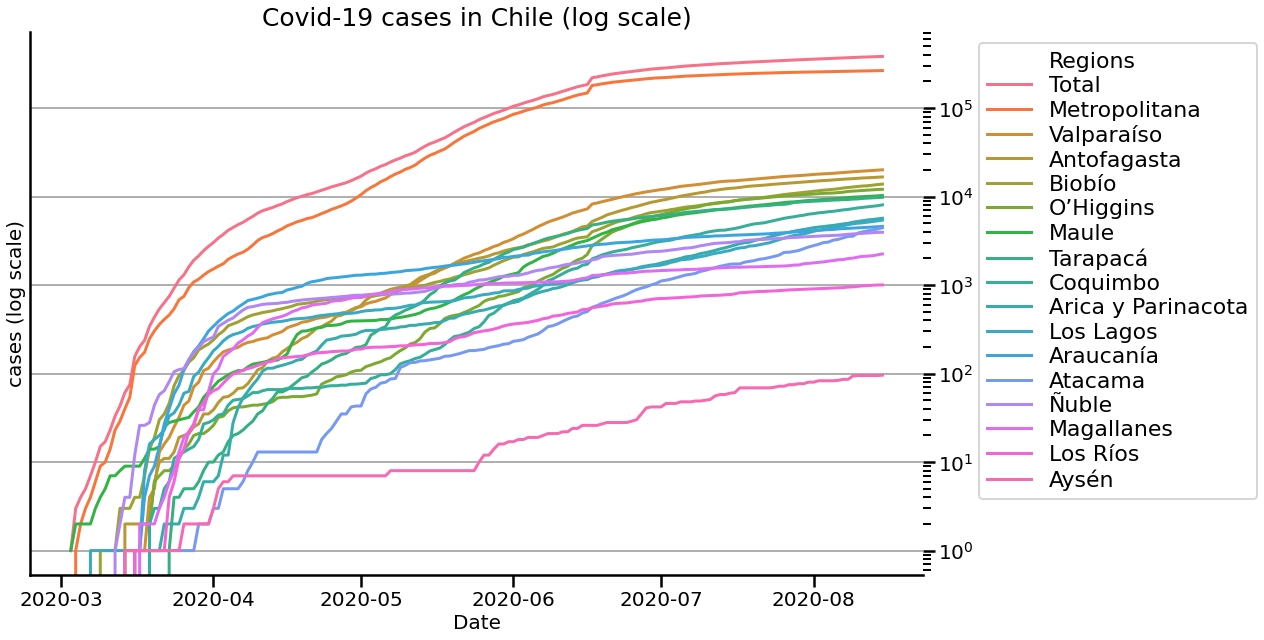

In [64]:
timeline_plot(cases_regions, 'cases')

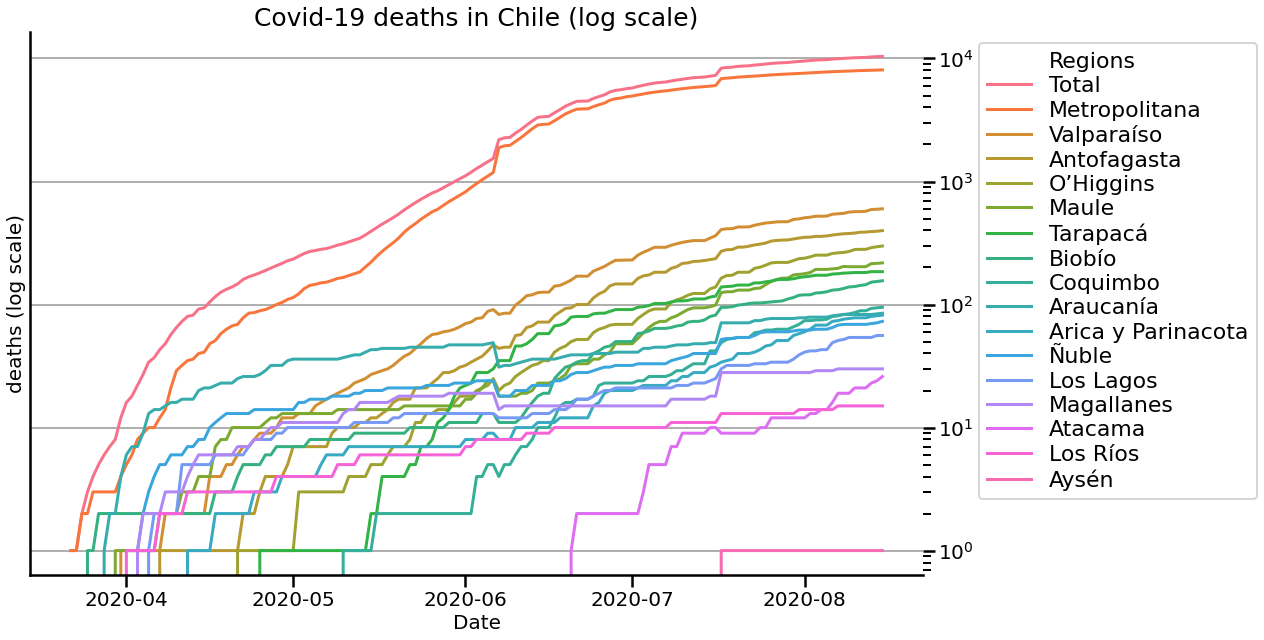

In [65]:
timeline_plot(deaths_regions, 'deaths')

In [66]:
# The CASEN data has a lot of columns with many NaNs: 
(np.sum(casen.isna() == True)/casen.shape[0]).sort_values(ascending = False).head(20)

e9com_p_cod    0.999751
e19_2          0.999580
y2004          0.999501
y20dmonto      0.999501
yama           0.999325
y0512          0.999316
y26_4h_mo      0.999307
yinv02         0.999252
y0511          0.999238
y26_4j_mo      0.999205
yah2           0.999178
y0509          0.999154
yrut           0.999154
y26_4e_mo      0.999099
ydon           0.999085
y0504          0.999039
yre2           0.999011
yre3           0.999011
y20bmonto      0.998826
y2002          0.998826
dtype: float64

In [68]:
def prepare_casen_data(df, col_to_drop, max_nan):
    """
    Function to prepare the CASEN data and realize the following steps: 
    Drop columns that are not necessary (e.g. date of interview), 
    consider only columns with less NaNs than the value of max_nan, 
    fill the rest of the columns with the mean,
    Change the region ID from numbers to names. 
    Print the histogram for four randomly selected columns. 
    
    Input: 
        df (DataFrame): DataFrame with CASEN data
        col_to_drop (list): List with columns that are not necessary
        max_nan (float): maximal value of permitted amount of NaNs in a column
        
    Output: 
        Plots four histograms of four randomly selected columns
        df_rel (DataFrame): DataFrame with CASEN data and without NaNs
    """
    
    # Drop columns that are not necessary
    df_rel = df.drop(col_to_drop, axis = 1)

    # Consider only columns with less NaNs than the value of max_nan
    df_rel = df_rel.loc[:, df_rel.isna().mean() < max_nan]
    df_rel = df_rel.loc[:, df_rel.isin([' ','NULL', 0]).mean() < .2]

    # Fill the rest of the columns with the mean
    df_rel = df_rel.fillna(casen_rel.mean())    
    
    # Change the region ID from numbers to names
    df_rel['region'] = df_rel['region'].map({1: 'Tarapacá',
                                               2: 'Antofagasta',
                                               3: 'Atacama',
                                               4: 'Coquimbo',
                                               5: 'Valparaíso',
                                               6: 'O’Higgins',
                                               7: 'Maule',
                                               8: 'Biobío',
                                               9: 'Araucanía', 
                                               10: 'Los Lagos',
                                               11: 'Aysén',
                                               12: 'Magallanes',
                                               13: 'Metropolitana',
                                               14: 'Los Ríos',
                                               15: 'Arica y Parinacota',
                                               16: 'Ñuble'})
    
    df_rel.sample(4, axis=1).hist(figsize = (12, 8), bins = 25)
    
    return df_rel

,region,zona,tot_hog,tot_per,tot_nuc,pres,pco1,nucleo,pco2,h10a,...,numper,esc,educ,activ,indmat,indsan,calglobviv,iae,iai,hacinamiento
0,Tarapacá,1,1,1,1,1.0,1,1,1,1.0,...,1.0,12.0,5,1.0,1,2,2,1,1,1
1,Tarapacá,1,1,1,1,1.0,1,1,1,1.0,...,1.0,7.0,1,1.0,1,1,1,1,1,1
2,Tarapacá,1,1,2,1,1.0,1,1,1,1.0,...,2.0,12.0,5,1.0,1,1,1,1,1,1
3,Tarapacá,1,1,2,1,3.0,3,1,3,1.0,...,2.0,12.0,5,1.0,1,1,1,1,1,1
4,Tarapacá,1,1,3,1,3.0,1,1,1,1.0,...,3.0,15.0,8,1.0,1,2,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216434,Arica y Parinacota,2,1,2,1,1.0,1,1,1,1.0,...,2.0,3.0,1,3.0,2,2,2,1,1,1
216435,Arica y Parinacota,2,1,2,1,1.0,2,1,2,1.0,...,2.0,4.0,1,1.0,2,2,2,1,1,1
216436,Arica y Parinacota,2,1,2,1,1.0,1,1,1,3.0,...,2.0,12.0,5,3.0,2,2,2,1,1,1
216437,Arica y Parinacota,2,1,2,1,3.0,2,1,2,1.0,...,2.0,3.0,1,1.0,2,2,2,1,1,1


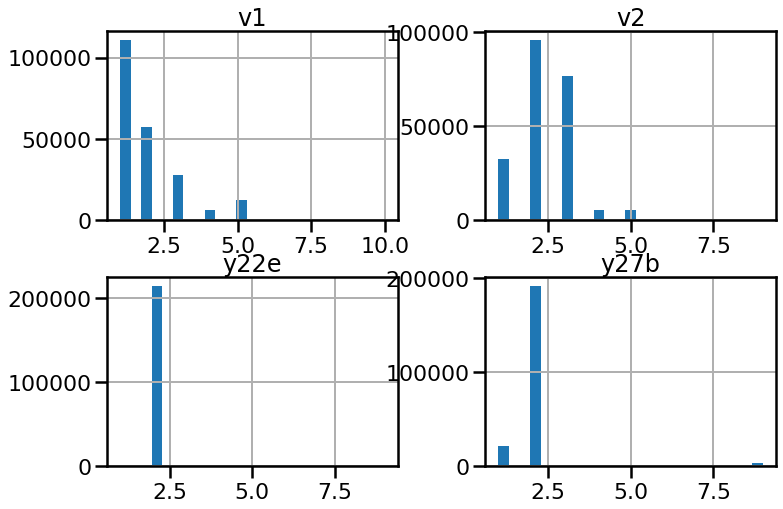

In [107]:
columns = ['folio', 
           'o', 
           'sexo',
           'asiste',
           'edad',
           'pareja', 
           'ecivil',
           'id_vivienda', 
           'hogar', 
           'varstrat', 
           'varunit', 
           'expr_div', 
           'expr', 
           'expc',
           'fecha_dia',
           'fecha_mes',
           'fecha_año',
           'provincia',
           'comuna']

casen_rel = prepare_casen_data(casen, columns, 0.2)

casen_rel

# Feature Engineering

## Analyze correlation of features with Covid-19 cases/deaths

In [126]:
def get_corr(df, casen_data, title):
    """
    Function to get the correlation between the CASEN socio-economic indicators and the number 
    of Covid-19 cases/deaths in Chile. 
    
    Input: 
        df (DataFrame): DataFrame with information about Covid-19 cases/deaths in Chile
        casen_data(DataFrame): DataFrame with CASEN data
        title: Specify the kind of the plot (cases or deaths) 
        
    Output: 
        corr (series): Series with pairwise correlation of CASEN indicators with amount of 
        Covid-19 cases/deaths in Chile. 
    """

    # Prepare df by transposing it (name of regions as rows)
    transposed_df = (np.transpose(df))
    
    # Change column names to dates
    transposed_df.columns = transposed_df.iloc[0, :]

    # Drop first row (no information)
    transposed_df = transposed_df.drop('Region', axis = 0).reset_index()
    transposed_df = transposed_df.rename(columns = {'index': 'region'})

    # Given that the DataFrame is updated every data, the name of the last column (the 
    # current amount of Covid-19 cases/deaths) changes every day. 
    last_column = new.columns[-1]
    
    # Store only the name of the region and the last column as new DataFrame
    df_result = transposed_df.loc[:, ['region', last_column]]
    df_result = df_result.rename(columns = {last_column: title})

    # Group CASEN data by regions by taking the mean of every indicator
    casen_regions = casen_data.groupby('region')[[i for i in casen_data.columns[1:]]].mean().reset_index()

    # Merge CASEN data and information about amount of Covid-19 cases/deaths
    casen_merged = casen_regions.merge(df_result, on = 'region')
    casen_merged = casen_merged.drop('region', axis = 1)

    # Change type of column title to float
    casen_merged[title] = casen_merged[title].astype('float')

    # Get correlation with title and sort values from highest correlation to lowest
    corr = casen_merged.corrwith(casen_merged[title]).sort_values(ascending = False)
    
    return corr

In [127]:
get_corr(cases_regions, casen_rel, 'cases')

cases         1.000000
v38e          0.691754
r1b           0.676207
v39e          0.651919
yauth         0.628890
                ...   
v2           -0.414425
calglobviv   -0.420014
v37c         -0.422773
v37g         -0.441782
v37i         -0.610127
Length: 159, dtype: float64

In [128]:
get_corr(deaths_regions, casen_rel, 'deaths')

deaths        1.000000
r1b           0.678264
v38e          0.675758
v39e          0.648735
yauth         0.634053
                ...   
ch1          -0.409244
v37c         -0.420374
calglobviv   -0.421440
v37g         -0.438086
v37i         -0.605715
Length: 159, dtype: float64

In [ ]:
# Next step: Visualize top 5 and lowest 5